# Application: Predict Social Perceptions from Human Faces
This notebook includes an application which predicts six social ratings (trustworthy, friendly, sociable, attractive, emotional, intelligent) from face images.

---

### Content:

- 1) Load Packages & Models
- 2) Preprocess Images
- 3) Write Application Function
- 4) Application on Public Images
- 5) Application on Webcam Images

---

# 1) Load Packages & Models

In [1]:
# load basic packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat  # this SciPy module loads mat-files
import matplotlib.image as mpimg
 
sns.set_style('white')
pd.options.display.max_columns = 100

In [2]:
# load trained model (trained on Google Colab)

from tensorflow.keras.models import load_model

models_path = '/Users/kacha/nf-ds/nf_capstone/models/final_models/'
model_T = load_model(models_path + 'm03d_resnet50_do_60ep_yT_Xf.h5') # 'm03d_API_resnet50_30ep_yT_Xf.h5') 

In [3]:
# model to predict friendliness
model_F = load_model(models_path + 'm03d_API_resnet50_30ep_yF_Xf.h5')

In [4]:
# model to predict sociability
model_S = load_model(models_path + 'm03d_resnet50_30ep_yS_Xf.h5')

In [5]:
# model to predict attractiveness
model_A = load_model(models_path + 'm03d_API_resnet50_30ep_yA_Xf.h5')

In [6]:
# model to predict intelligence
model_I = load_model(models_path + 'm03d_resnet50_10ep_yI_Xf.h5')

In [7]:
# model to predict emotionality
model_E = load_model(models_path + 'm03d_API_resnet50_30ep_yE_Xf.h5')

In [8]:
# load social ratings of 10k US face dataset to calculate percentiles

data_path = '/Users/kacha/nf-ds/nf_capstone/data/'

yT = np.load(data_path + 'yT.npy')
yF = np.load(data_path + 'yF.npy')
yS = np.load(data_path + 'yS.npy')
yA = np.load(data_path + 'yA.npy')
yI = np.load(data_path + 'yI.npy')
yE = np.load(data_path + 'yE.npy')

---
# 2) Preprocess Images

In [9]:
# write function to extract face from image (version 1: with distortion as input for model)

from mtcnn import MTCNN
from PIL import Image

def extract_face(image_array, target_size=(224, 224)):

    # bring image array in correct format (0-255)
    #image_array = (image_array*255).astype('uint8')
    max_height = image_array.shape[0]
    max_width = image_array.shape[1]

    # create the detector, using default weights
    detector = MTCNN()
 
    # detect faces in the image
    results = detector.detect_faces(image_array)
  
    # extract the bounding box from the first face (ensure positive result)
    x1, y1, width, height = results[0]['box']
    #print(x1, y1, width, height)

    x1_n = max(0, x1)
    y1_n = max(0, y1)
    width_n = width - abs(x1-x1_n)
    height_n = height - abs(y1-y1_n)

    x2, y2 = x1_n + width_n, y1_n + height_n
    #print(x1_n, y1_n, width_n, height_n)

    x2_n = min(max_width, x2)
    y2_n = min(max_height, y2)
    #print(x2, y2, x2_n, y2_n)

    # extract the face
    face = image_array[y1_n:y2_n, x1_n:x2_n]

    # resize pixels to the model size
    image = Image.fromarray(face).resize(target_size)
    #image = image.resize(target_size)
    face_array = np.asarray(image) / 255.

    return face_array

Using TensorFlow backend.


In [10]:
# write function to extract face from image (version 2: without distortion for plotting)

def extract_face_without_distortion(image_array, target_size=(224, 224)):

    # bring image array in correct format (0-255)
    #image_array = (image_array*255).astype('uint8')
    max_height = image_array.shape[0]
    max_width = image_array.shape[1]

    # create the detector, using default weights
    detector = MTCNN()
 
    # detect faces in the image
    results = detector.detect_faces(image_array)
  
    # extract the bounding box from the first face (ensure positive result)
    x1, y1, width, height = results[0]['box']
    #print(x1, y1, width, height)

    x_center = x1 + width/2
    y_center = y1 + height/2
    
    size = max(width, height)
    x1_new = int(x_center - size/2)
    y1_new = int(y_center - size/2)
    
    x2_new = int(x_center + size/2)
    y2_new = int(y_center + size/2)
    
    x1_corr = max(0, x1_new)
    y1_corr = max(0, y1_new)
    
    x2_corr = min(x2_new, max_width)
    y2_corr = min(y2_new, max_height)    

    # extract the face
    face = image_array[y1_corr:y2_corr, x1_corr:x2_corr]

    # resize pixels to the model size
    image = Image.fromarray(face).resize(target_size)
    face_array = np.asarray(image) / 255.

    return face_array

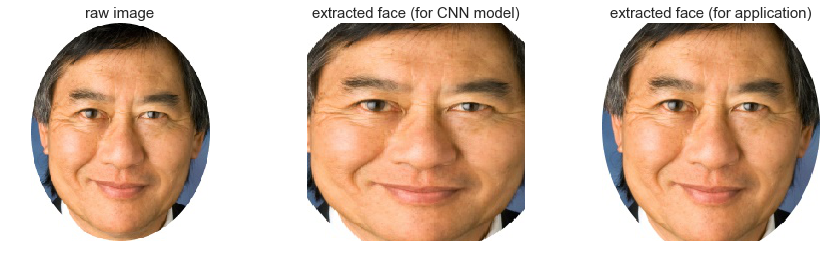

In [11]:
# load and show example image: raw, extracted face (for modeling), extracted face (without distortion)

img_path = '/Users/kacha/Pictures/'
file = 'Face_Example.jpg' # 'Frau_braun.jpg'
img = mpimg.imread(img_path + file)

plt.figure(figsize=(15,4))

plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.title('raw image', size=15);

plt.subplot(132)
face = extract_face(img)
plt.imshow(face)
plt.axis('off')
plt.title('extracted face (for CNN model)', size=15);

plt.subplot(133)
face2 = extract_face_without_distortion(img)
plt.imshow(face2)
plt.axis('off')
plt.title('extracted face (for application)', size=15);

In [12]:
# preprocess_input function of vggface adapted from: 
# https://github.com/rcmalli/keras-vggface/blob/master/keras_vggface/utils.py

def preprocess_input_vggface(x):
    
    x_temp = x*255 # np.copy(x)
    x_temp = x_temp[..., ::-1]
    x_temp[..., 0] -= 91.4953
    x_temp[..., 1] -= 103.8827
    x_temp[..., 2] -= 131.0912

    return x_temp

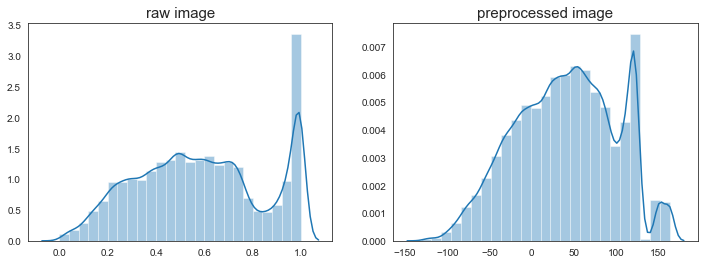

In [13]:
# check pixel value distribution of raw and preprocessed images

plt.figure(figsize=(12,4))
plt.subplot(121)
sns.distplot(face.ravel(), bins=25)
plt.title('raw image', size=15);
plt.subplot(122)
sns.distplot(preprocess_input_vggface(face).ravel(), bins=25)
plt.title('preprocessed image', size=15);

---
# 3) Write Application Function

In [31]:
# write function to make prediction for social perceptions from image

def rate_face(image_file, show_plot=True):
    
    # extract face from image
    img = mpimg.imread(image_file)
    face = extract_face(img)
    face2 = extract_face_without_distortion(img)
    
    # preprocess image
    face_input = preprocess_input_vggface(face)
    face_input = np.expand_dims(face_input, axis=0)
    
    # make predictions for all attributes: raw values (1-9)
    pred_T = model_T.predict(face_input).ravel()[0]
    pred_F = model_F.predict(face_input).ravel()[0]
    pred_S = model_S.predict(face_input).ravel()[0]
    pred_A = model_A.predict(face_input).ravel()[0]
    pred_E = model_E.predict(face_input).ravel()[0]    
    pred_I = model_I.predict(face_input).ravel()[0] 
    pred = [pred_T, pred_F, pred_S, pred_A, pred_E, pred_I]

    # make predictions for all attributes: percentiles (0%-100%)
    rel_pred_T = (yT <= pred_T).sum() / len(yT) * 100
    rel_pred_F = (yF <= pred_F).sum() / len(yF) * 100
    rel_pred_S = (yS <= pred_S).sum() / len(yS) * 100
    rel_pred_A = (yA <= pred_A).sum() / len(yA) * 100
    rel_pred_E = (yE <= pred_E).sum() / len(yE) * 100
    rel_pred_I = (yI <= pred_I).sum() / len(yI) * 100  
    rel_pred = [rel_pred_T, rel_pred_F, rel_pred_S, rel_pred_A, rel_pred_E, rel_pred_I]
        
    # plotting
    if show_plot:
        attribute_list = ['trustworthy','friendly','sociable','attractive','emotional', 'intelligent']
        plt.figure(figsize=(16,5))

        # left plot: face
        plt.subplot(121)
        plt.imshow(face2)
        plt.axis('off');

        # right plot: ratings
        plt.subplot(122)
        sns.set(font_scale=2, style='white')
        sns.barplot(x=[100]*len(attribute_list), y=attribute_list,
                    label="total", linewidth=1.0, edgecolor=".2", color='white')
        sns.barplot(x=rel_pred, y=attribute_list, 
                    label="ratings", linewidth=1.0, edgecolor=".2", palette='viridis') #clrs)
        sns.despine(left=True, bottom=True)
        
        plt.show()

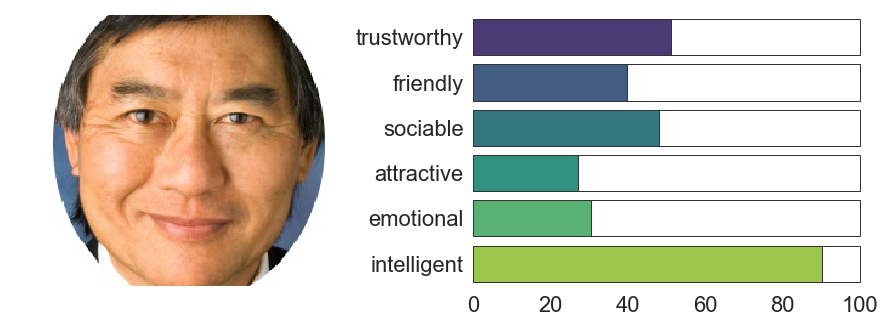

In [32]:
# create example image for GitHub readme

database_path = '/Users/kacha/nf-ds/nf_capstone/10k_US_Data/Publication Friendly 49-Face Database/49 Face Images/'
rate_face(database_path + '4900851395_1287eea7b5_o.jpg') 

---
# 4) Application on Public Images

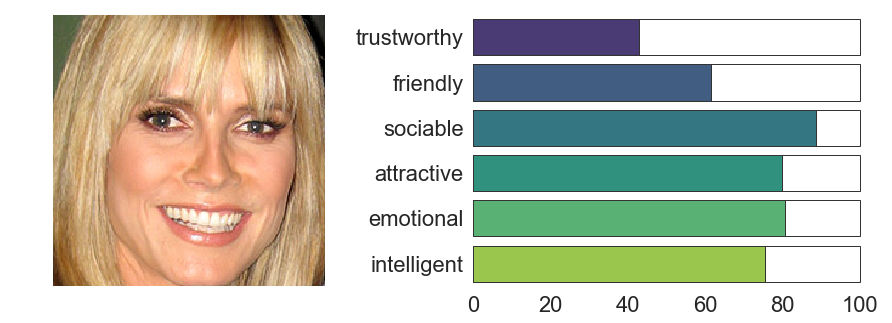

In [33]:
rate_face(img_path + 'Heidi_Klum_2010.jpg')
# image source:
# By Bob Bekian from Thousand Oaks Ca., USA - Heidi Klum, CC BY 2.0, 
# https://commons.wikimedia.org/w/index.php?curid=19715669

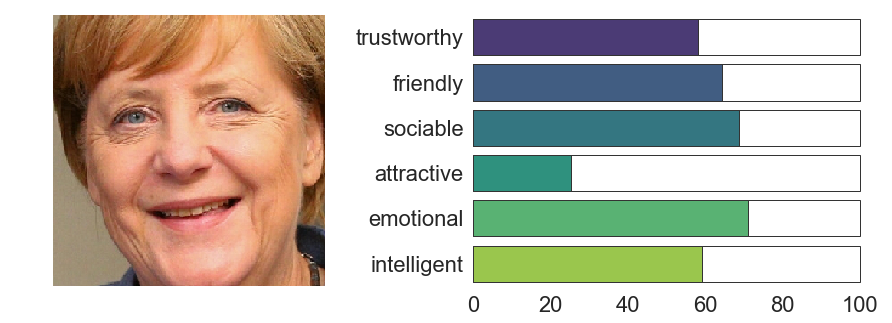

In [30]:
rate_face(img_path + 'Angela_Merkel_2017.jpg')
# image source:
# By EU2017EE Estonian Presidency - This file has been extracted from another file: 
# Tallinn Digital Summit. Welcome dinner hosted by HE Donald Tusk. Handshake (36669383664).jpg, CC BY 2.0, 
# https://commons.wikimedia.org/w/index.php?curid=63047045

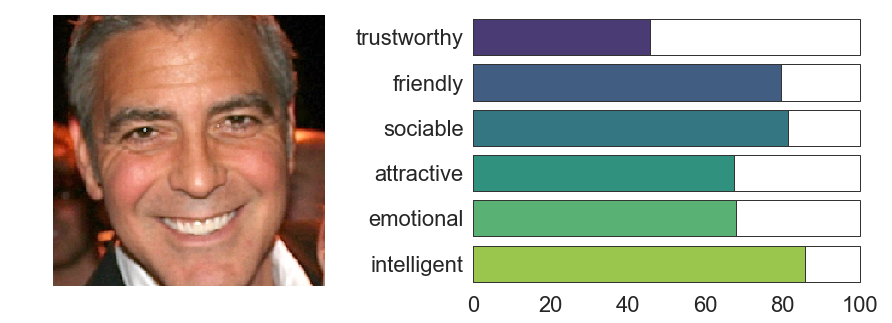

In [25]:
rate_face(img_path + 'George_Clooney_2012.jpg')
# image source:
# By Thescrutineer - Own work, CC BY-SA 3.0, 
# https://commons.wikimedia.org/w/index.php?curid=32437331

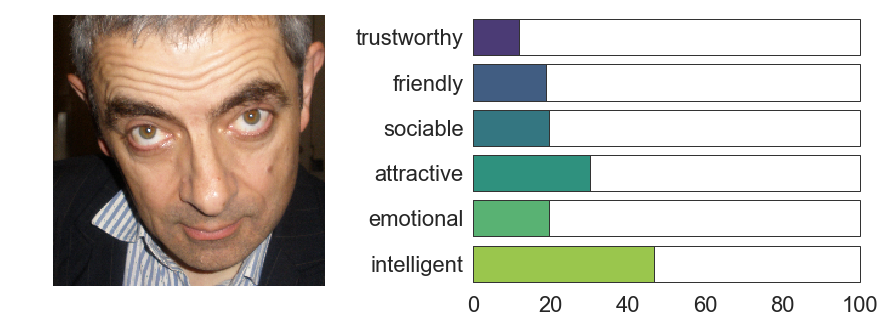

In [29]:
rate_face(img_path + 'Rowan_Atkinson_2009.jpg')
# image source: 
# By Standish77 at English Wikipedia, CC BY-SA 3.0, 
# https://commons.wikimedia.org/w/index.php?curid=7546393

---
# 5) Application on Webcam Images

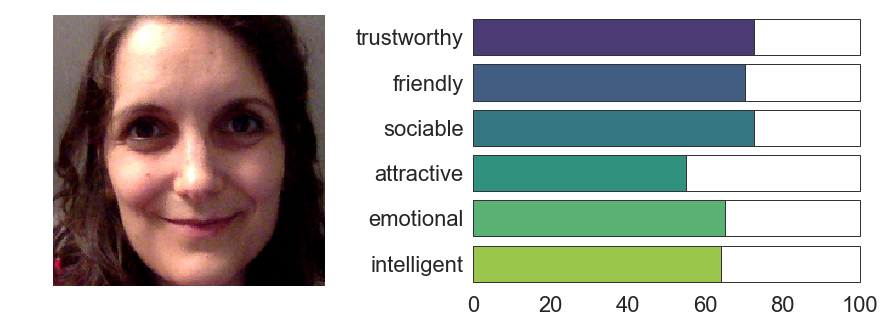

In [19]:
rate_face(img_path + 'Karima.jpg')
# picture taken with my webcam on January 2020